In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import cm
from tqdm import tqdm
import os
import torch
torch.cuda.empty_cache()
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numpy import linalg as la
from numpy import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from solver_edmd_torch_gpu_sde import KoopmanNNTorch, KoopmanSolverTorch
from solver_edmd_torch_gpu_sde import KoopmanNNTorch, KoopmanSolverTorch
from solver_gedmd_torch_gpu import KoopmanNNTorch as KoopmanNNTorch_g
from solver_gedmd_torch_gpu import  KoopmanSolverTorch as KoopmanSolverTorch_g
print (torch.__version__, torch.cuda.is_available())
print(torch.version.cuda)
print (torch.cuda.get_device_name())
# device= 'cpu'
device= 'cuda'

2.5.1 True
12.4
NVIDIA A40


In [2]:
import torch
torch.cuda.empty_cache()

In [3]:
def ou_process_1d(theta=1, mu=0, sigma=1, X0=0, n_steps=10000, n_eval=200, h=1e-5):
    """
    Simulates the Ornstein-Uhlenbeck process.
    
    Parameters:
    - theta: rate of mean reversion
    - mu: long-term mean of the process
    - sigma: volatility
    - X0: initial value
    - n_steps: number of steps in each evaluation
    - n_eval: number of evaluations
    - h: Integration step size
    
    Returns:
    - A numpy array containing the simulated values at each evaluation
    """
    X_eval = np.zeros(n_eval)
    X = X0
    
    for i in range(n_eval):
        for _ in range(n_steps):
            dW = np.sqrt(h) * np.random.randn()
            X = X + theta * (mu - X) * h + sigma * dW
        X_eval[i] = X
    
    return X_eval

## Setup the parameters
theta = 1
mu = 0
sigma = 0.1

In [4]:
# Generate m initial points from the domain space [-2, 2]
m = 10
n_eval = 200
n_steps = 1000
h = 1e-4
lag_time = n_steps * h
print("lag time: ", lag_time)
X0_values = np.linspace(-2, 2, m)

# Initialize the data_matrix
data_matrix = np.zeros((m, n_eval+1, 1))

# Simulate trajectories for each initial point and store them in the data_matrix
for i, X0 in tqdm(enumerate(X0_values), total=m, desc="Simulating trajectories"):
    X_eval = np.concatenate(([X0], ou_process_1d(X0=X0, n_steps=n_steps, n_eval=n_eval, h=h)))
    data_matrix[i, :, 0] = X_eval

# Print the shape of data_matrix
print("Shape of data_matrix:", data_matrix.shape)

# Extract data_X and data_Y from the data matrix
data_X = data_matrix[:, :-1, :]
data_Y = data_matrix[:, 1:, :]
print(f"Shape of data_X: {data_X.shape}")
print(f"Shape of data_Y: {data_Y.shape}")

# Reshape data_X and data_Y into a single column
X = data_X.reshape(-1, data_X.shape[2])  # 2D features
Y = data_Y.reshape(-1, data_X.shape[2])  # 2D targets
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

# Separate data into two parts: train and validation
len_all = X.shape[0]
data_x_train = X[:int(0.7*len_all)]
data_x_valid = X[int(0.7*len_all)+1:]

data_y_train = Y[:int(0.7*len_all)]
data_y_valid = Y[int(0.7*len_all)+1:]

data_train = [data_x_train, data_y_train]
data_valid = [data_x_valid, data_y_valid]

print(data_x_train.shape)

lag time:  0.1


Simulating trajectories: 100%|██████████| 10/10 [00:02<00:00,  3.76it/s]

Shape of data_matrix: (10, 201, 1)
Shape of data_X: (10, 200, 1)
Shape of data_Y: (10, 200, 1)
Shape of X: (2000, 1)
Shape of Y: (2000, 1)
(1400, 1)


In [5]:
checkpoint_file= 'ou1d_example_ckpt002.torch'

from solver_edmd_torch_gpu_sde import KoopmanNNTorch, KoopmanSolverTorch

basis_function = KoopmanNNTorch(input_size=1, layer_sizes=[20, 20], n_psi_train=18).to(device)

solver = KoopmanSolverTorch(dic=basis_function, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                       reg=0.1,  checkpoint_file= checkpoint_file, fnn_checkpoint_file= 'example_fnn_ou_001.torch', a_b_file= 'a_b_example_ou.jbl',
                generator_batch_size= 4, fnn_batch_size= 32, delta_t= lag_time)

data_x_train_tensor = torch.DoubleTensor(data_x_train).to (device)#, requieres_grad= True)#, dtype=tf.float64)
data_y_train_tensor = torch.DoubleTensor(data_y_train).to (device)#, requires_grad= True)#, dtype=tf.float64)

In [6]:
solver.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=6,
    batch_size=256,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8
    )

Epoch: 1 	Training Loss: 0.307817 val loss: 0.249634
saving, val loss enhanced: 0.24963372019079522 10000
Epoch: 2 	Training Loss: 0.301590 val loss: 0.243681
saving, val loss enhanced: 0.24368060947127873 0.24963372019079522
Epoch: 3 	Training Loss: 0.293263 val loss: 0.240854
saving, val loss enhanced: 0.2408538352760476 0.24368060947127873
Epoch: 4 	Training Loss: 0.285615 val loss: 0.233897
saving, val loss enhanced: 0.23389667646850007 0.2408538352760476
Epoch: 5 	Training Loss: 0.279828 val loss: 0.229349
saving, val loss enhanced: 0.22934856530970166 0.23389667646850007
Epoch: 6 	Training Loss: 0.274971 val loss: 0.220750
saving, val loss enhanced: 0.22075012985626963 0.22934856530970166
Epoch: 7 	Training Loss: 0.272372 val loss: 0.216630
saving, val loss enhanced: 0.21662972557939686 0.22075012985626963
Epoch: 8 	Training Loss: 0.261752 val loss: 0.212728
saving, val loss enhanced: 0.21272849335219482 0.21662972557939686
Epoch: 9 	Training Loss: 0.259559 val loss: 0.207195
sav

Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 7734.49iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
saving FNN a and b to:  a_b_example_ou.jbl
Outer Epoch 1/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 7708.56iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 42907.017378 val loss: 41804.316281
saving, val loss enhanced: 41804.31628061302 1000000000000000.0
Epoch: 2 	Training Loss: 42843.382649 val loss: 41742.561000
saving, val loss enhanced: 41742.56099960167 41804.31628061302


/workspace/solver_edmd_torch_gpu_sde.py:300: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file)


Epoch: 3 	Training Loss: 42780.185392 val loss: 41680.893708
saving, val loss enhanced: 41680.893707584386 41742.56099960167
Epoch: 4 	Training Loss: 42717.072889 val loss: 41619.290029
saving, val loss enhanced: 41619.290029285614 41680.893707584386
Epoch 1 time: 8.27 seconds
Outer Epoch 2/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 7993.86iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 50037.992630 val loss: 48751.049992
Epoch: 2 	Training Loss: 49962.144480 val loss: 48676.033867
Epoch: 3 	Training Loss: 49885.144189 val loss: 48600.603160
Epoch: 4 	Training Loss: 49807.938293 val loss: 48525.280072
Epoch 2 time: 7.28 seconds
Outer Epoch 3/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 9663.11iteration/s] 


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 59657.457515 val loss: 58119.405952
Epoch: 2 	Training Loss: 59561.683023 val loss: 58024.323289
Epoch: 3 	Training Loss: 59464.041248 val loss: 57928.660584
Epoch: 4 	Training Loss: 59366.195836 val loss: 57833.356487
Epoch 3 time: 6.56 seconds
Outer Epoch 4/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 8638.44iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 71978.692375 val loss: 70117.798938
Epoch: 2 	Training Loss: 71855.955333 val loss: 69995.874521
Epoch: 3 	Training Loss: 71730.796689 val loss: 69873.379714
Epoch: 4 	Training Loss: 71605.615302 val loss: 69751.664249
Epoch 4 time: 7.03 seconds
Outer Epoch 5/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 8398.63iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 528.327196 val loss: 514.817756
saving, val loss enhanced: 514.817755851711 41619.290029285614
Epoch: 2 	Training Loss: 527.770361 val loss: 514.453168
saving, val loss enhanced: 514.4531681578163 514.817755851711
Epoch: 3 	Training Loss: 527.461429 val loss: 514.249619
saving, val loss enhanced: 514.249618788378 514.4531681578163
Epoch: 4 	Training Loss: 527.288238 val loss: 514.134147
saving, val loss enhanced: 514.1341472356336 514.249618788378
Epoch 5 time: 7.10 seconds
Outer Epoch 6/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 9689.76iteration/s] 


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 543.334044 val loss: 529.799621
Epoch: 2 	Training Loss: 543.274610 val loss: 529.757675
Epoch: 3 	Training Loss: 543.237413 val loss: 529.730055
Epoch: 4 	Training Loss: 543.212235 val loss: 529.710136
Epoch 6 time: 6.59 seconds


/workspace/solver_edmd_torch_gpu_sde.py:684: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.checkpoint_file)


In [7]:
# Results from solver_edmd/solver_resdmd
evalues = solver.eigenvalues.T
efuns = solver.eigenfunctions(X)
N_dict = np.shape(evalues)[0]
Koopman_matrix_K = solver.K
outputs = {
    'efuns': efuns,
    'evalues': evalues,
    'N_dict': N_dict,
    'K': Koopman_matrix_K
    }

[-4.21983574e-05+0.j -1.04915861e+00+0.j -1.85931928e+00+0.j
 -3.15286353e+00+0.j]


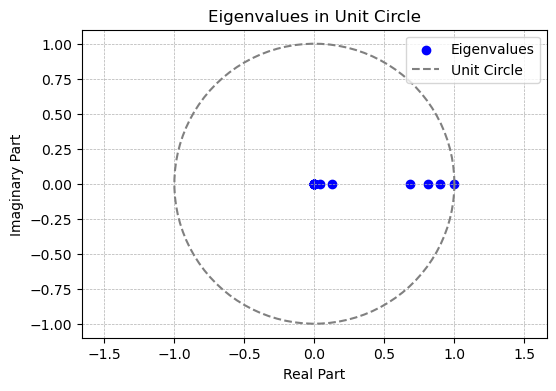

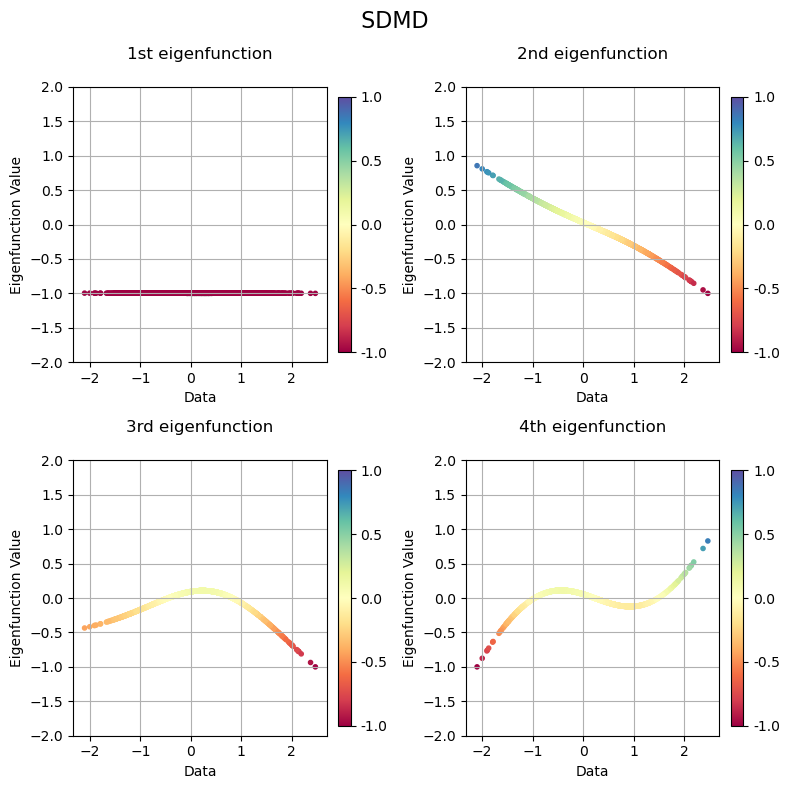

In [9]:
# Take ln values of the eigenvalues and divide by 0.1
# ln_evalues = np.log(evalues[:4]) / lag_time
ln_evalues = (evalues[:4]-1) / lag_time

print(ln_evalues)

## Plot eigenvalues on unit circle
# Assuming evalues is a numpy array of complex numbers
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

## Plot eigenfunctions
# Get the real part of eigenfunctions and normalize them
phi = np.real(efuns)

# Use the entire efuns instead of slicing
for i in range(len(evalues)):
    phi[:, i] = phi[:, i] / np.max(np.abs(phi[:, i]))

# Create a plot with 2x2 layout
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
titles = ['1st eigenfunction', '2nd eigenfunction', '3rd eigenfunction', '4th eigenfunction']

# Determine global min and max values for the eigenfunctions for a uniform scale
vmin = np.min(phi)
vmax = np.max(phi)
cbar_ticks = np.linspace(vmin, vmax, 5)

# Flatten the 2D array of axes for easy iteration
axs_flat = axs.flatten()

for i, (ax, title) in enumerate(zip(axs_flat, titles)):
    scatter = ax.scatter(X, phi[:, i], c=phi[:, i], cmap='Spectral', marker='.', vmin=vmin, vmax=vmax)
    ax.set_title(title, pad=20)
    ax.set_xlabel('Data')
    ax.set_ylabel('Eigenfunction Value')
    ax.set_ylim(-2, 2)
    cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, ticks=cbar_ticks)
    cbar.set_ticklabels([f"{tick:.1f}" for tick in cbar_ticks])
    ax.grid()
fig.suptitle(' SDMD ', fontsize=16)
plt.tight_layout()
plt.show()

In [10]:
basis_function_g = KoopmanNNTorch_g(input_size=1, layer_sizes=[20, 20], n_psi_train=18).to(device)

solver_g = KoopmanSolverTorch_g(dic=basis_function, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                       reg=0.1,  checkpoint_file= checkpoint_file, fnn_checkpoint_file= 'example_fnn_ou_001.torch',  a_b_file= 'a_b_example_ou.jbl',
                generator_batch_size= 4, fnn_batch_size= 32)

In [11]:
solver_g.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=6,
    batch_size=32,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8,   
    )

Precomputed SDE coefficients loaded from: a_b_example_ou.jbl
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 8923.21iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Outer Epoch 1/6
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 8998.88iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 10341.87iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 11960/11960 [00:01<00:00, 9526.09iteration/s]


Epoch: 1 	Training Loss: 1.306966 val loss: 1.281293
saving, val loss enhanced: 1.2812929957181705 1000000000000000.0
Epoch: 2 	Training Loss: 1.284175 val loss: 1.259074
saving, val loss enhanced: 1.2590744772121962 1.2812929957181705
Epoch: 3 	Training Loss: 1.261411 val loss: 1.237075
saving, val loss enhanced: 1.2370750813452007 1.2590744772121962
Epoch: 4 	Training Loss: 1.238970 val loss: 1.215447
saving, val loss enhanced: 1.2154474127779566 1.2370750813452007


/workspace/solver_gedmd_torch_gpu.py:309: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file)


Epoch 1 time: 16.71 seconds
Outer Epoch 2/6
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 9665.27iteration/s] 


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 9590.64iteration/s] 


cuda:0


Computing dPsi_X: 100%|██████████| 11960/11960 [00:01<00:00, 9778.28iteration/s] 


Epoch: 1 	Training Loss: 1.107325 val loss: 1.089382
saving, val loss enhanced: 1.0893824139475812 1.2154474127779566
Epoch: 2 	Training Loss: 1.090674 val loss: 1.073244
saving, val loss enhanced: 1.0732439833173923 1.0893824139475812
Epoch: 3 	Training Loss: 1.074123 val loss: 1.057145
saving, val loss enhanced: 1.0571449134654185 1.0732439833173923
Epoch: 4 	Training Loss: 1.057641 val loss: 1.041146
saving, val loss enhanced: 1.0411461330517198 1.0571449134654185
Epoch 2 time: 16.26 seconds
Outer Epoch 3/6
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 9419.68iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 9704.40iteration/s] 


cuda:0


Computing dPsi_X: 100%|██████████| 11960/11960 [00:01<00:00, 9219.96iteration/s]


Epoch: 1 	Training Loss: 0.980583 val loss: 0.967202
saving, val loss enhanced: 0.9672019749694478 1.0411461330517198
Epoch: 2 	Training Loss: 0.967379 val loss: 0.954404
saving, val loss enhanced: 0.9544036702146718 0.9672019749694478
Epoch: 3 	Training Loss: 0.954265 val loss: 0.941646
saving, val loss enhanced: 0.9416457851852735 0.9544036702146718
Epoch: 4 	Training Loss: 0.941201 val loss: 0.928949
saving, val loss enhanced: 0.9289491081673603 0.9416457851852735
Epoch 3 time: 16.28 seconds
Outer Epoch 4/6
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 9010.61iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 9927.05iteration/s] 


cuda:0


Computing dPsi_X: 100%|██████████| 11960/11960 [00:01<00:00, 9641.21iteration/s] 


Epoch: 1 	Training Loss: 0.896290 val loss: 0.885793
saving, val loss enhanced: 0.8857926434772082 0.9289491081673603
Epoch: 2 	Training Loss: 0.885282 val loss: 0.875117
saving, val loss enhanced: 0.8751171740432544 0.8857926434772082
Epoch: 3 	Training Loss: 0.874347 val loss: 0.864480
saving, val loss enhanced: 0.8644795126907948 0.8751171740432544
Epoch: 4 	Training Loss: 0.863452 val loss: 0.853888
saving, val loss enhanced: 0.853888112843983 0.8644795126907948
Epoch 4 time: 16.15 seconds
Outer Epoch 5/6
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 9047.73iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 9842.73iteration/s] 


cuda:0


Computing dPsi_X: 100%|██████████| 11960/11960 [00:01<00:00, 9667.37iteration/s] 


Epoch: 1 	Training Loss: 0.839091 val loss: 0.830457
saving, val loss enhanced: 0.8304570091717213 0.853888112843983
Epoch: 2 	Training Loss: 0.829565 val loss: 0.821215
saving, val loss enhanced: 0.8212145270611064 0.8304570091717213
Epoch: 3 	Training Loss: 0.820099 val loss: 0.812007
saving, val loss enhanced: 0.8120069365270732 0.8212145270611064
Epoch: 4 	Training Loss: 0.810668 val loss: 0.802838
saving, val loss enhanced: 0.802837676759986 0.8120069365270732
Epoch 5 time: 16.26 seconds
Outer Epoch 6/6
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 9481.21iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 9130.44iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 11960/11960 [00:01<00:00, 9555.00iteration/s]


Epoch: 1 	Training Loss: 0.800727 val loss: 0.793287
saving, val loss enhanced: 0.7932867733371017 0.802837676759986
Epoch: 2 	Training Loss: 0.792244 val loss: 0.785054
saving, val loss enhanced: 0.7850536021032511 0.7932867733371017
Epoch: 3 	Training Loss: 0.783811 val loss: 0.776853
saving, val loss enhanced: 0.7768530423518897 0.7850536021032511
Epoch: 4 	Training Loss: 0.775411 val loss: 0.768686
saving, val loss enhanced: 0.7686859081231011 0.7768530423518897


/workspace/solver_gedmd_torch_gpu.py:696: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.checkpoint_file)


Epoch 6 time: 16.33 seconds
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 9930.26iteration/s] 


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0


In [12]:
evalues = solver_g.eigenvalues.T
efuns = solver_g.eigenfunctions(X)
N_dict = np.shape(evalues)[0]
Psi_X = solver_g.get_Psi_X()
Psi_Y = solver_g.get_Psi_Y()
outputs = {
    'efuns': efuns,
    'evalues': evalues,
    'N_dict': N_dict
    }

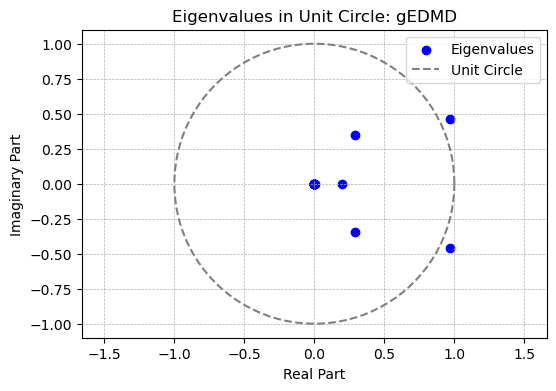

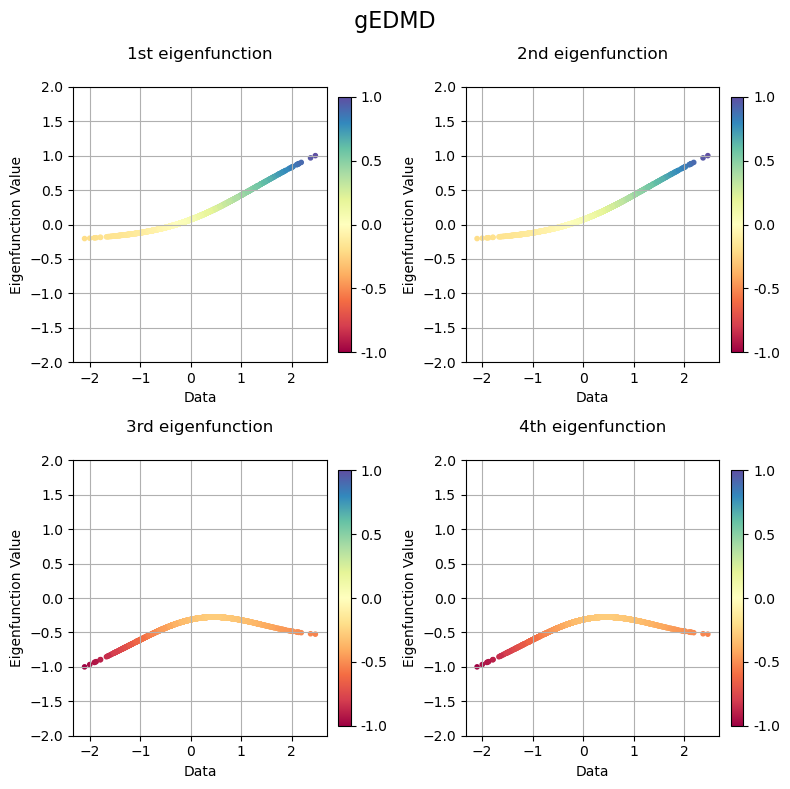

In [13]:
## Plot eigenvalues on unit circle
# Assuming evalues is a numpy array of complex numbers
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle: gEDMD')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

## Plot eigenfunctions
# Get the real part of eigenfunctions and normalize them
phi = np.real(efuns)

# Use the entire efuns instead of slicing
for i in range(len(evalues)):
    phi[:, i] = phi[:, i] / np.max(np.abs(phi[:, i]))

# Create a plot with 2x2 layout
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
titles = ['1st eigenfunction', '2nd eigenfunction', '3rd eigenfunction', '4th eigenfunction']

# Determine global min and max values for the eigenfunctions for a uniform scale
vmin = np.min(phi)
vmax = np.max(phi)
cbar_ticks = np.linspace(vmin, vmax, 5)

# Flatten the 2D array of axes for easy iteration
axs_flat = axs.flatten()

for i, (ax, title) in enumerate(zip(axs_flat, titles)):
    scatter = ax.scatter(X, phi[:, i], c=phi[:, i], cmap='Spectral', marker='.', vmin=vmin, vmax=vmax)
    ax.set_title(title, pad=20)
    ax.set_xlabel('Data')
    ax.set_ylabel('Eigenfunction Value')
    ax.set_ylim(-2, 2)
    cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, ticks=cbar_ticks)
    cbar.set_ticklabels([f"{tick:.1f}" for tick in cbar_ticks])
    ax.grid()
fig.suptitle(' gEDMD ', fontsize=16)
plt.tight_layout()
plt.show()